In [19]:
import pandas as pd
import numpy as np
import os
import wfdb
from scipy import signal
import neurokit2 as nk
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt

# ==============================================================================
# LANGKAH 0: PERSIAPAN DAN PEMBUATAN PETA FILE
# ==============================================================================

# --- KONFIGURASI ---
base_path = r'C:\Users\HP\Documents\ptbdb'
file_path_klinis = os.path.join(base_path, 'metadata_klinis_ekg.csv')

# --- MEMBUAT PETA LOKASI FILE (SOLUSI UTAMA) ---
print("Memindai direktori untuk membuat peta lokasi file...")
file_map = {}
for root, dirs, files in os.walk(base_path):
    for filename in files:
        if filename.endswith('.hea'):
            record_name = filename.split('.')[0]
            # Simpan path lengkap TANPA ekstensi file
            file_map[record_name] = os.path.join(root, record_name)

print(f"Peta lokasi file berhasil dibuat. Ditemukan {len(file_map)} rekaman unik.")

# Muat DataFrame klinis
df_klinis = pd.read_csv(file_path_klinis)
print(f"DataFrame klinis berhasil dimuat dengan {len(df_klinis)} baris.")

Memindai direktori untuk membuat peta lokasi file...
Peta lokasi file berhasil dibuat. Ditemukan 549 rekaman unik.
DataFrame klinis berhasil dimuat dengan 549 baris.


In [20]:
# ==============================================================================
# LANGKAH 1: FUNGSI-FUNGSI PEMBANTU (VERSI BARU)
# ==============================================================================

def load_ecg_signal_from_map(record_name, file_map):
    """Fungsi baru yang memuat sinyal menggunakan peta file yang sudah dibuat."""
    try:
        # Langsung ambil path yang benar dari peta
        record_path = file_map.get(record_name)
        if record_path:
            ecg_record = wfdb.rdrecord(record_path)
            ecg_signal = ecg_record.p_signal[:, :12]
            fs = ecg_record.fs
            return ecg_signal, fs
        else:
            # Jika record tidak ada di peta
            return None, None
    except Exception as e:
        # print(f"Error saat membaca record {record_name}: {e}")
        return None, None

def filter_signal(signal_data, fs):
    """Fungsi filter, tidak ada perubahan."""
    lowcut, highcut = 0.5, 45.0
    nyquist = 0.5 * fs
    b, a = signal.butter(2, [lowcut / nyquist, highcut / nyquist], btype='band')
    return signal.filtfilt(b, a, signal_data, axis=0)

In [ ]:
# ==============================================================================
# LANGKAH 2: EKSTRAKSI FITUR (MENGGUNAKAN FUNGSI BARU)
# ==============================================================================

list_fitur_sinyal = []
gagal_records = []

for index, row in tqdm(df_klinis.iterrows(), total=df_klinis.shape[0], desc="Mengekstrak Fitur Sinyal"):
    record_name = row['Record']
    
    # Memanggil fungsi pemuat yang baru dan lebih cerdas
    raw_signal, fs = load_ecg_signal_from_map(record_name, file_map)
    
    if raw_signal is not None and fs is not None:
        try:
            filtered_signal = filter_signal(raw_signal, fs)
            signals, info = nk.ecg_process(filtered_signal[:, 1], sampling_rate=fs)
            hrv_features = nk.hrv(info, sampling_rate=fs)
            
            fitur_saat_ini = {
                'Record': record_name,
                'Rata_Rata_HR': signals['ECG_Rate'].mean(),
                'HRV_SDNN': hrv_features.get('HRV_SDNN', pd.Series([np.nan])).iloc[0],
                'HRV_RMSSD': hrv_features.get('HRV_RMSSD', pd.Series([np.nan])).iloc[0]
            }
            list_fitur_sinyal.append(fitur_saat_ini)
        except Exception as e:
            # Jika error terjadi saat pemrosesan sinyal (bukan saat memuat)
            gagal_records.append(record_name)
    else:
        # Jika error terjadi saat memuat file
        gagal_records.append(record_name)

df_fitur_sinyal = pd.DataFrame(list_fitur_sinyal)
print(f"\n--- Ekstraksi Selesai ---")
print(f"Berhasil diekstrak: {len(df_fitur_sinyal)} rekaman.")
print(f"Gagal diekstrak: {len(gagal_records)} rekaman.")

In [ ]:
# ==============================================================================
# LANGKAH 3: PENGGABUNGAN DAN PEMBERSIHAN
# ==============================================================================

if not df_fitur_sinyal.empty:
    df_lengkap = pd.merge(df_klinis, df_fitur_sinyal, on='Record', how='left')
    
    # Kita buang baris yang gagal diekstrak fiturnya ATAU yang punya nilai fitur NaN
    df_bersih = df_lengkap.dropna(subset=['Rata_Rata_HR', 'HRV_SDNN', 'HRV_RMSSD'])
    
    print(f"\nJumlah data setelah digabung dan dibersihkan: {len(df_bersih)}")
    print("\nDistribusi kelas di DataFrame final yang bersih:")
    print(df_bersih['Diagnosis'].value_counts())
    
    # Simpan hasil bersih untuk digunakan nanti
    final_output_path = os.path.join(base_path, 'dataset_final_untuk_ml.csv')
    df_bersih.to_csv(final_output_path, index=False)
    print(f"\nDataset bersih siap pakai telah disimpan di: {final_output_path}")

else:
    print("\nTidak ada fitur yang berhasil diekstrak. Proses dihentikan.")

In [21]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.impute import SimpleImputer

In [22]:
# ==============================================================================
# LANGKAH 4: MEMUAT, GROUPING, DAN ENCODING
# ==============================================================================
print("--- Langkah 0 & 1: Memuat, Grouping, dan Encoding ---")
file_path_final = r"C:\Users\HP\Documents\ptbdb\dataset_final_untuk_ml.csv" 
df_final = pd.read_csv(file_path_final)

# Grouping Kelas
replacement_map = {
    'Heart failure (NYHA 2)': 'Heart failure', 'Heart failure (NYHA 3)': 'Heart failure',
    'Heart failure (NYHA 4)': 'Heart failure', 'Stable angina': 'Angina/Other Symptoms',
    'Unstable angina': 'Angina/Other Symptoms', 'Palpitation': 'Angina/Other Symptoms',
    'Hypertrophy': 'Myocardial hypertrophy'
}
df_final['Diagnosis'] = df_final['Diagnosis'].replace(replacement_map)

final_output_path = os.path.join(base_path, 'dataset_final_untuk_ml_final.csv')
df_final.to_csv(final_output_path, index=False)

# One-Hot Encoding
kolom_untuk_encode = df_final.select_dtypes(include=['object']).columns.tolist()
if 'Record' in kolom_untuk_encode: kolom_untuk_encode.remove('Record')
if 'Diagnosis' in kolom_untuk_encode: kolom_untuk_encode.remove('Diagnosis')
df_encoded = pd.get_dummies(df_final, columns=kolom_untuk_encode, dummy_na=False)
print("Persiapan data awal selesai.")

--- Langkah 0 & 1: Memuat, Grouping, dan Encoding ---
Persiapan data awal selesai.


In [23]:
# ==============================================================================
# LANGKAH 5: PERSIAPAN AKHIR & TRAIN-TEST SPLIT
# ==============================================================================
print("\n--- Langkah 2: Persiapan dan Pemisahan Data ---")
df_encoded['Diagnosis_ID'] = df_encoded['Diagnosis'].astype('category').cat.codes
y = df_encoded['Diagnosis_ID']
X = df_encoded.drop(columns=['Record', 'Diagnosis', 'Diagnosis_ID'])

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42, stratify=y
)
print("Pemisahan data berhasil.")


--- Langkah 2: Persiapan dan Pemisahan Data ---
Pemisahan data berhasil.


In [24]:
# ==============================================================================
# LANGKAH 5.5: IMPUTASI UNTUK MENANGANI NILAI NaN
# ==============================================================================
print("\n--- Langkah 2.5: Menangani Nilai NaN dengan Imputasi Median ---")
imputer = SimpleImputer(strategy='median')
imputer.fit(X_train)
X_train = imputer.transform(X_train)
X_test = imputer.transform(X_test)
print("Penanganan nilai NaN selesai.")


--- Langkah 2.5: Menangani Nilai NaN dengan Imputasi Median ---
Penanganan nilai NaN selesai.


In [25]:
# ==============================================================================
# LANGKAH 6: MENANGANI KETIDAKSEIMBANGAN KELAS (SMOTE)
# ==============================================================================
print("\n--- Langkah 3: Menerapkan SMOTE pada Data Latih ---")
# --- PERBAIKAN FINAL DI SINI ---
# Atur k_neighbors menjadi 1, karena kelas terkecil di data latih hanya memiliki 2 anggota (2-1=1).
smote = SMOTE(random_state=42, k_neighbors=1)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)
print("Proses SMOTE selesai.")


--- Langkah 3: Menerapkan SMOTE pada Data Latih ---
Proses SMOTE selesai.


In [26]:
# ==============================================================================
# LANGKAH 7: MELATIH MODEL MACHINE LEARNING
# ==============================================================================
print("\n--- Langkah 4: Melatih Model RandomForestClassifier ---")
model = RandomForestClassifier(n_estimators=150, random_state=42)
model.fit(X_train_resampled, y_train_resampled)
print("Pelatihan model selesai.")


--- Langkah 4: Melatih Model RandomForestClassifier ---
Pelatihan model selesai.



--- Langkah 5: Mengevaluasi Model pada Data Uji ---

Laporan Klasifikasi:
                        precision    recall  f1-score   support

 Angina/Other Symptoms       0.00      0.00      0.00         1
   Bundle branch block       0.00      0.00      0.00         4
        Cardiomyopathy       0.29      0.50      0.36         4
           Dysrhythmia       0.33      0.50      0.40         4
       Healthy control       1.00      1.00      1.00        20
         Heart failure       0.00      0.00      0.00         1
Myocardial hypertrophy       0.00      0.00      0.00         2
 Myocardial infarction       0.94      0.97      0.95        92
           Myocarditis       0.00      0.00      0.00         1
Valvular heart disease       0.00      0.00      0.00         1

             micro avg       0.87      0.87      0.87       130
             macro avg       0.26      0.30      0.27       130
          weighted avg       0.84      0.87      0.85       130


Confusion Matrix:


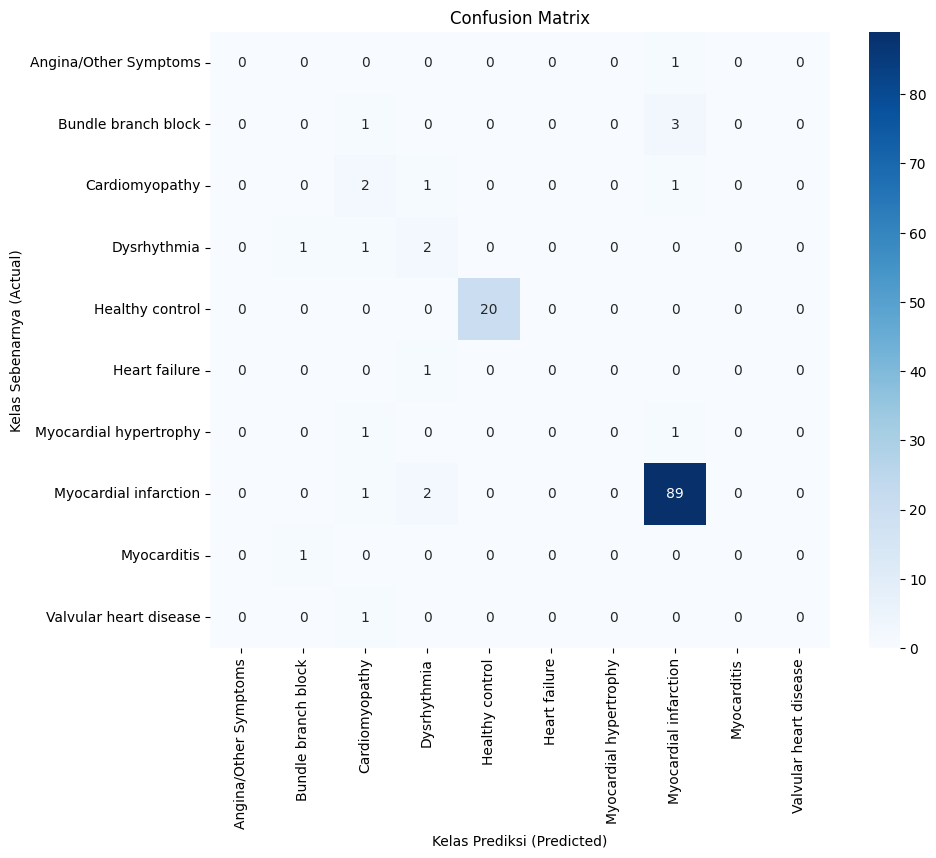

In [27]:
# ==============================================================================
# LANGKAH 8 - Mengevaluasi Model pada Data Uji
# ==============================================================================
print("\n--- Langkah 5: Mengevaluasi Model pada Data Uji ---")

# y_pred seharusnya sudah ada dari Langkah 4 sebelumnya
# model juga sudah dilatih
y_pred = model.predict(X_test)

# Buat mapping dari ID ke nama diagnosis untuk laporan yang lebih mudah dibaca
diagnosis_mapping = dict(enumerate(df_final['Diagnosis'].astype('category').cat.categories))
target_names = list(diagnosis_mapping.values())

# Definisikan label ID yang kita harapkan (0, 1, 2, ..., 9)
expected_labels = list(diagnosis_mapping.keys())

print("\nLaporan Klasifikasi:")
# --- PERBAIKAN FINAL DI SINI ---
# Tambahkan parameter 'labels' untuk memastikan tidak ada kebingungan
print(classification_report(y_test, y_pred, 
                            labels=expected_labels, 
                            target_names=target_names, 
                            zero_division=0))

print("\nConfusion Matrix:")
# labels juga ditambahkan di sini untuk konsistensi
cm = confusion_matrix(y_test, y_pred, labels=expected_labels)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=target_names, yticklabels=target_names)
plt.title('Confusion Matrix')
plt.ylabel('Kelas Sebenarnya (Actual)')
plt.xlabel('Kelas Prediksi (Predicted)')
plt.show()

In [28]:
# ==============================================================================
# LANGKAH 9 - Menyimpan Model
# ==============================================================================
import joblib
import os

# --- MENYIMPAN MODEL YANG SUDAH DILATIH ---

# 1. Tentukan nama file untuk model Anda
#    Konvensi yang baik adalah menggunakan ekstensi .joblib atau .pkl
nama_file_model = 'model_ekg_randomforest.joblib'
path_model = os.path.join(base_path, nama_file_model) # base_path dari script sebelumnya

# 2. Gunakan joblib.dump untuk menyimpan objek 'model' ke dalam file
#    'model' adalah nama variabel yang berisi model RandomForest Anda yang sudah dilatih
joblib.dump(model, path_model)

print(f"Model berhasil disimpan di lokasi: {path_model}")

Model berhasil disimpan di lokasi: C:\Users\HP\Documents\ptbdb\model_ekg_randomforest.joblib


In [12]:
import pandas as pd
import joblib
import os
import numpy as np
from sklearn.impute import SimpleImputer

In [13]:
# ==============================================================================
# LANGKAH 10 - Persiapan & Memuat Aset
# ==============================================================================

print("--- Memuat Model dan Dataset Master ---")

# Definisikan path yang dibutuhkan
base_path = r'C:\Users\HP\Documents\ptbdb' # Sesuaikan jika perlu
model_path = os.path.join(base_path, 'model_ekg_randomforest.joblib')
data_path = os.path.join(base_path, 'dataset_final_untuk_ml_final.csv')

# Muat model yang sudah dilatih
model_terlatih = joblib.load(model_path)
print("Model berhasil dimuat.")

# Muat dataset master yang bersih
df_final = pd.read_csv(data_path)
print("Dataset master berhasil dimuat.")

--- Memuat Model dan Dataset Master ---
Model berhasil dimuat.
Dataset master berhasil dimuat.


In [14]:
# ==============================================================================
# LANGKAH 11 - Proses Ulang Data Agar Sesuai Format Training
# ==============================================================================

print("\n--- Mempersiapkan Data Fitur (X) ---")

# 1. One-Hot Encoding
kolom_untuk_encode = df_final.select_dtypes(include=['object']).columns.tolist()
if 'Record' in kolom_untuk_encode: kolom_untuk_encode.remove('Record')
if 'Diagnosis' in kolom_untuk_encode: kolom_untuk_encode.remove('Diagnosis')
df_encoded = pd.get_dummies(df_final, columns=kolom_untuk_encode, dummy_na=False)

# 2. Definisikan X (kumpulan fitur lengkap)
# --- PERBAIKAN DI SINI ---
# Kita hanya drop 'Record' dan 'Diagnosis' karena 'Diagnosis_ID' belum ada
X_full = df_encoded.drop(columns=['Record', 'Diagnosis'])

# 3. Imputasi (Menangani NaN)
imputer = SimpleImputer(strategy='median')
X_full_imputed = imputer.fit_transform(X_full)
X_full_imputed = pd.DataFrame(X_full_imputed, columns=X_full.columns)
print("Data fitur (X) berhasil dibuat dan dibersihkan.")


--- Mempersiapkan Data Fitur (X) ---
Data fitur (X) berhasil dibuat dan dibersihkan.


In [ ]:
# ==============================================================================
# LANGKAH 12 - Ambil Sampel Dan Lakukan Prediksi
# ==============================================================================

print("\n--- Melakukan Prediksi pada Sampel ---")
# Ambil satu sampel data untuk diuji (misalnya, data pasien ke-50)
nomor_sampel = 44
sampel_tunggal = X_full_imputed.iloc[[nomor_sampel]]
data_asli_pasien = df_final.iloc[nomor_sampel]


# Lakukan prediksi dengan model yang sudah dimuat
prediksi_id = model_terlatih.predict(sampel_tunggal)
prediksi_probabilitas = model_terlatih.predict_proba(sampel_tunggal)

# Buat mapping dari ID ke nama diagnosis untuk interpretasi
# Kita buat mapping dari data df_final yang asli
df_final['Diagnosis_ID'] = df_final['Diagnosis'].astype('category').cat.codes
diagnosis_mapping = dict(enumerate(df_final['Diagnosis'].astype('category').cat.categories))
nama_diagnosis_prediksi = diagnosis_mapping.get(prediksi_id[0], "ID Tidak Dikenal")
probabilitas_tertinggi = np.max(prediksi_probabilitas) * 100

print(f"\n--- Hasil Prediksi untuk Pasien '{data_asli_pasien['Record']}' ---")
print(f"Diagnosis Asli Pasien: '{data_asli_pasien['Diagnosis']}'")
print(f"Model Memprediksi Diagnosis: '{nama_diagnosis_prediksi}'")
print(f"Dengan Tingkat Keyakinan: {probabilitas_tertinggi:.2f}%")


--- Melakukan Prediksi pada Sampel ---
🚀 ~ sampel_tunggal:     Age  Sex  Rata_Rata_HR    HRV_SDNN   HRV_RMSSD  Smoker_n  Smoker_no  \
1  81.0  0.0      55.82645  680.174831  962.427702       0.0        1.0   

   Smoker_unknown  Smoker_yes  Acute_Infarction_Localization_anterior  ...  \
1             0.0         0.0                                     0.0  ...   

   Additional_Diagnoses_Stent  Additional_Diagnoses_Struma (euthyroid)  \
1                         0.0                                      0.0   

   Additional_Diagnoses_Synkope, Stable angina, Aortic stenosis (gradient 90mmHg), Varicosis  \
1                                                0.0                                           

   Additional_Diagnoses_Tinnitus  \
1                            0.0   

   Additional_Diagnoses_Ventricular fibrillation, Arterial hypertension, Diabetes mellitus, Hyperlipoproteinemia Type IIb, Renal insufficiency  \
1                                                0.0                   

c:\Python311\Lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
c:\Python311\Lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
